# NEURON Exercise: The AMPA-NMDA Synapse Model

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Introduction

In this exercise, we will work more in-depth with the AMPA-NMDA synapse model constructed in the NMODL language tutorial, and explore some of its properties using simulation.

**Important**: Ensure you have downloaded the MOD files, and compiled them with NMODL in Week 4 Exercise 1.  It is only necessary to do this once for all Week 4 exercises. 

## Initialize NEURON

In [1]:
import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

## A neuron to host your synapse

Following previous exercises, we will create a single compartment soma neuron to host the synapse.

In [30]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

In [31]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

Create the synapse at the center of the soma compartment

In [32]:
synapse = h.SimpleAMPA_NMDA(soma(0.5))

Define the stimulus: 8 spikes at 20Hz + 1 spike 500 ms later

In [33]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

In [34]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

1.0

First, let's zero the NMDA conductance, and validate that the AMPA conductance is behaving as we expect
First we simulate, then we plot the voltage, and the conductance trajectories.

In [35]:
h.tstop = 1000.0 # ms
synapse.gmax_NMDA = 0.0
synapse.gmax_AMPA = 0.001 # uS
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


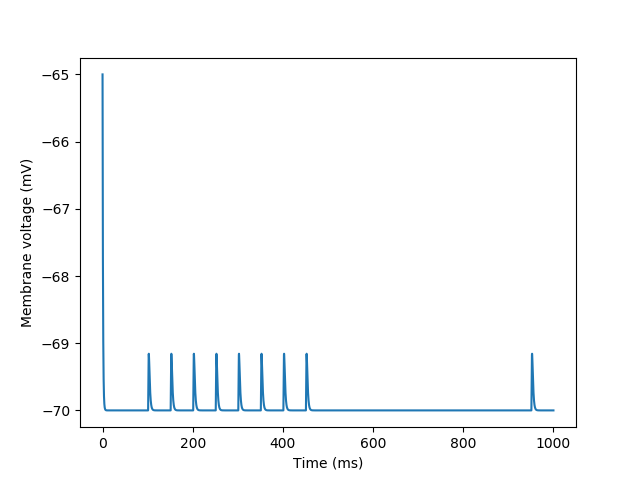

In [36]:
# This command gives us fancy interactive inline plots
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()
        
plot_timecourse(time, v_soma)

The dual exponential model for the conductance time course has a closed form for the response due to a single pulse.
Below we validate our .mod file implementation running in NEURON against this closed form solution. 

<IPython.core.display.Javascript object>


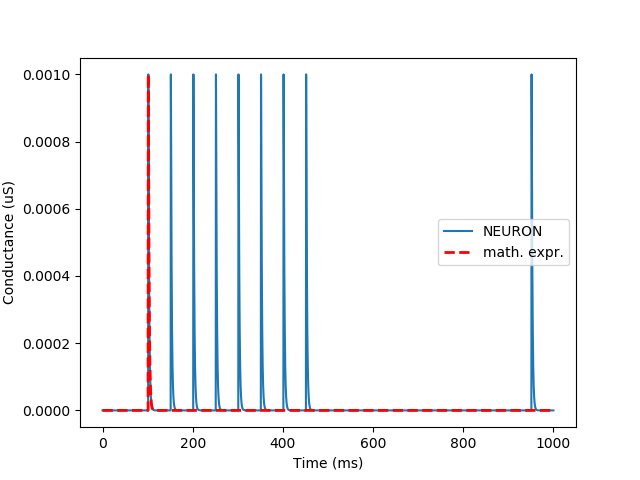

In [37]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp
    
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_AMPA, synapse.tau_d_AMPA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

Now, let's also validate the trajectory for the NMDA receptor alone
Here, we have to remove the Magnesium block by zeroing the Mg2+ concentration

In [38]:
synapse.gmax_NMDA = 0.001 # uS
synapse.mg = 0.0 # mM
synapse.gmax_AMPA = 0 # uS
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


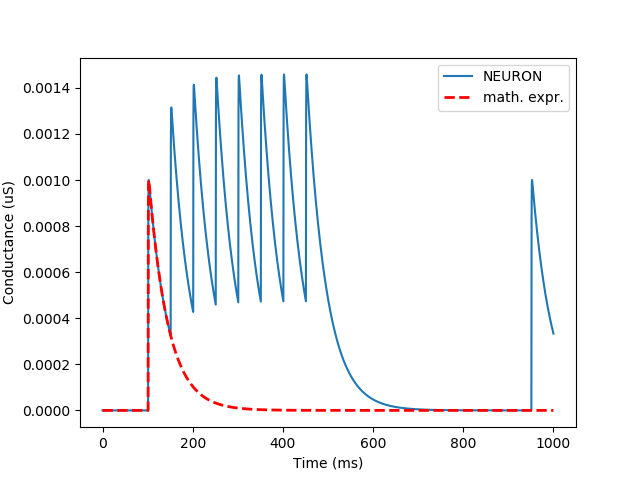

In [39]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_NMDA, synapse.tau_d_NMDA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

Finally, let's configure the synapse to realistic biological ranges for the AMPA and NMDA conductances, and the Mg2+ concentration.  We'll record both the NMDA and AMPA conductances serperately to visualize their contributions to the total conductance trajectory.

In [40]:
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


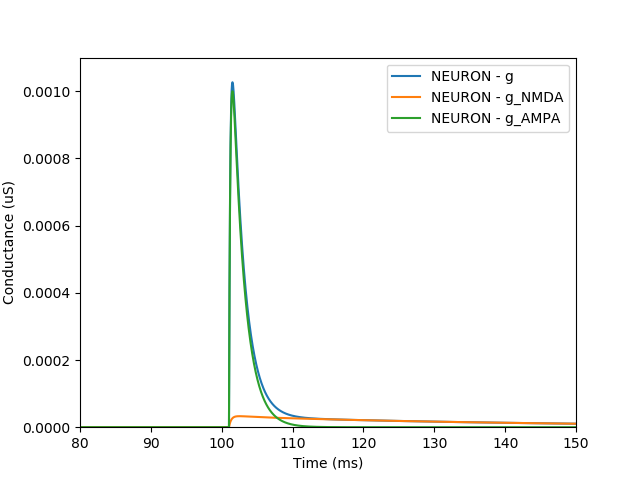

In [41]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON - g")
plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="NEURON - g_NMDA", newfigure=False)
plot_timecourse(time, g_AMPA, ylabel="Conductance (uS)", label="NEURON - g_AMPA", newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()

Finally, let's plot the dependence of the NMDA conductance on the Mg2+ concentration.

In [42]:
g_NMDA_1mM = numpy.zeros_like(g_NMDA)
g_NMDA_1mM[:] = g_NMDA

<IPython.core.display.Javascript object>


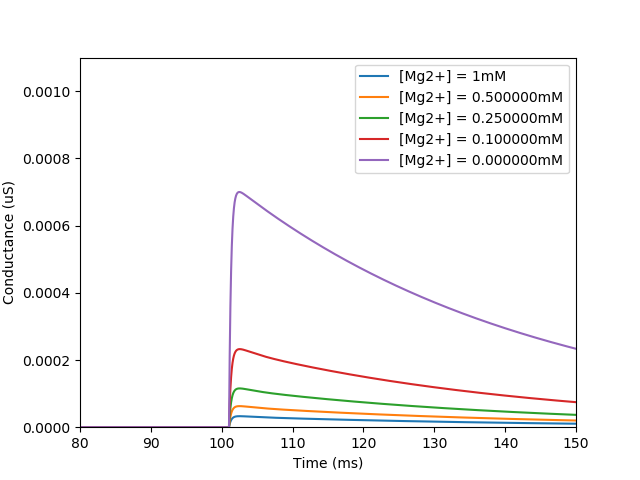

In [43]:
plot_timecourse(time, g_NMDA_1mM, ylabel="Conductance (uS)", label="[Mg2+] = 1mM")
mgs = [0.5, 0.25, 0.1, 0.0]
for mg in mgs:
    synapse.mg = mg
    neuron.h.run()
    plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="[Mg2+] = %fmM" % mg, newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()


The plot shows a marked increase in g_NMDA as [Mg2+] decreases, indicating the NMDA receptor requires the presence of Mg2+ for the voltage block to be effective.

Now, let's assess the voltage block curve of NMDA for [Mg2+]=1.0 in an _in silico_ reproduction the seminal experiment in Jahr and Stevens, 1990.

To do this, we need to:
1) Block the AMPA component of the conductance
2) Voltage clamp the soma at a given holding voltage
3) Run the stimulation simulation and extract the peak synaptic conductance
4) Repeat for different holding voltages
5) Fit the dependence of peak conductance on holding voltage to a sigmoid, plot.

We'll go through (1)-(3) below, and leave (4) and (5) to you the student as the exercise.

In [16]:
# 1) Block the AMPA component of the conductance
synapse.mg = 1.0 # [mM]
synapse.gmax_AMPA = 0.0 # Apply an "in silico AMPA blocker"
                        # Some things are easy in simulation ... 

In [17]:
# 2) Voltage clamp the soma at a given holding voltage
voltage_clamp = h.VClamp(0.5, sec=soma) # Create a voltage clamp electrode object and place it in the soma
voltage_clamp.amp[0] = -80.0 # Assign a clamping voltage
voltage_clamp.dur[0] = h.tstop # Clamp for the whole simulation duration

In [18]:
# 3) Run the stimulation simulation and extract the peak synaptic conductance
def extract_peaks(time, trace, event_times, window=10):
    """
    Computes the peak between event_times and returns the times of occurence and the maximums
    Useful for finding PSP or conductance peaks due to synaptic events.
    kwarg 'window' defines the time in ms after the event to consider when searching for the peak
    """
    
    peaks_list = []
    peaks_times_list = []
    for event_time in event_times:
        i_start = time.searchsorted(event_time)
        i_end = time.searchsorted(event_time+window)
        # find the index where the max occurs
        i_max = numpy.argmax(trace[i_start:i_end])
        # append the time and value at the max to the respective lists
        peaks_times_list.append(time[i_start:i_end][i_max])
        peaks_list.append(trace[i_start:i_end][i_max])
        
    return numpy.array(peaks_times_list), numpy.array(peaks_list)

In [19]:
def gNMDApeak_for_vclamp(v_clamp, eventNth=0):
    """returns the peak g_NMDA of the "eventNth" synaptic event for a given holding voltage"""
    voltage_clamp.amp[0] = v_clamp # Assign the clamping voltage
    neuron.h.run() # Simulate!
    g_NMDA = numpy.array(g_syn) # Get the resulting conductance as a numpy array (its only NMDA: AMPA is blocked) 
    time_arr = numpy.array(time) # Convert time h.Vector to a numpy array for subsequent operations
    peak_times, peaks = extract_peaks(time_arr, numpy.array(g_NMDA), spike_times) # extract the peaks and times
    peak_times_idx = time_arr.searchsorted(peak_times) # find array index of peak times 
    return peaks[eventNth] # return the peak conductance of the eventNth peak

In [20]:
gNMDApeak_for_vclamp(-80.0)

1.7098858648658307e-05

## Exercise

To submit answers to these questions and get feedback, please return to the edX platform.

**Question 1**

4) Determine, as above, the g_NMDA peak for different holding voltages.
Hint: Use the above function, and loop, or use list comprehension.
Plot it. How does it look?



In [21]:
# The range over which to assess the g_NMDA peak conductance
v_range = numpy.linspace(-80.0, 60.0, 10)

[-80.         -64.44444444 -48.88888889 -33.33333333 -17.77777778
  -2.22222222  13.33333333  28.88888889  44.44444444  60.        ]
[1.7098858648658307e-05, 4.3144287593762606e-05, 0.00010288564095909282, 0.000217907189531005, 0.00037974007016477811, 0.00052970281571851287, 0.00062357617761094909, 0.00066875479112437958, 0.00068774936183765162, 0.00069527730854197897]


<IPython.core.display.Javascript object>


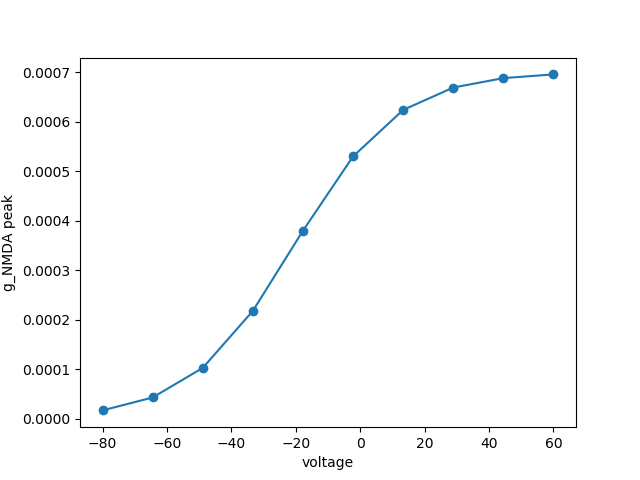

In [26]:
# Computing g_NMDA peak for different holding voltages, and plotting g_NMDA peak
# vs holding voltage should result in a sigmoidal curve, due to the voltage block of NMDA,
# which is progressively released for larger holding voltages.

%matplotlib notebook
 
g_NMDA_peak = []
 
for voltage in v_range:
    g_NMDA_peak.append(gNMDApeak_for_vclamp(voltage))
 
   
print v_range
print g_NMDA_peak
 
plt.plot(v_range, g_NMDA_peak,'o-')
plt.xlabel('voltage')
plt.ylabel('g_NMDA peak')
plt.show()


**Question 2**

5) Fit a sigmoid to the g_NMDA peak conductance dependence on holding voltage, and plot.
Hint: Use the fit function, and [curve_fit](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.curve_fit.html) (part of scipy) provided below.

Plot the simulation data and fit on the same axes.  Did *curve_fit* converge to a good fit?
How do the resulting fit parameters a & b compare to what was presented in the lecture, as determined by Jahr and Stevens, 1990 ?

In [23]:
fit_func = lambda x, a, b: synapse.gmax_NMDA/(1.0 + a*numpy.exp(-x/b))

In [24]:
# The curve fitter to use
from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>


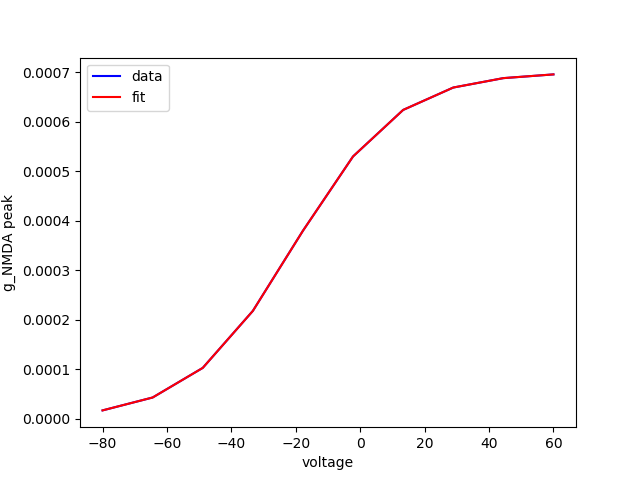

[  0.28011931  16.12950463]


In [25]:
# Fitting the provided sigmoidal function should result in fit parameters as follows:
# a = 1/3.57 and b=16.13, which are the parameters of the sigmoidal voltage block of
# NMDA determined experimentally in Jahr & Stevens, 1990.
 
%matplotlib notebook
 
xdata = v_range
ydata = g_NMDA_peak
 
plt.plot(xdata, ydata, 'b-', label='data')
 
popt, pcov = curve_fit(fit_func, xdata, ydata)
print popt
 
plt.plot(xdata, fit_func(xdata, *popt), 'r-', label='fit')
 
plt.xlabel('voltage')
plt.ylabel('g_NMDA peak')
plt.legend()
plt.show()